## Solution - Build a Multivariable Linear Regression model to predict the Traffic for shared supply (independent variables)
### Assumptions 

1) A linear relationship is assumed between the dependent variable and the independent variables

2) All independent variables are independent of each other (As supply of one category should not influence supply of other Tiers). Thus, the correlation between the input variables should be very low

3) Regression residuals must be normally distributed

4) There shouldn't be autocorrelation in the residuals



### Step 1) Import all necessary libraries


In [1]:
#For Visualizations & data wrangling
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pylab
import pandas as pd
import math

#For stats and variation analysis
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

#For linear regression model
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Step 2) Import file for input and output variables and check for NULLs

In [2]:
#Load data into Pandas
xls = pd.ExcelFile("~/Downloads/Sr.Manager_FC_Projections_Case Study.xlsx")
df1 = pd.read_excel(xls,'Traffic')
df2 = pd.read_excel(xls,'Content Supply')

#Check for NULL values in the input datasets
display('-'*100)
display(df1.isnull().any())
display('-'*100)
display(df2.isnull().any())

'----------------------------------------------------------------------------------------------------'

Date       False
Traffic    False
dtype: bool

'----------------------------------------------------------------------------------------------------'

Date no                False
Tier 1 - Video         False
Tier 2  - Video        False
Tier 2 - Video         False
Tier 4 - Video         False
Tier 5 - Video         False
Tier 6 - Video         False
Tier 7 - Video         False
Tier 8 - Video         False
Tier 9 - Video         False
Tier 1 - Non Video     False
Tier 2  - Non Video    False
Tier 2 - Non Video     False
Tier 4 - Non Video     False
Tier 5 - Non Video     False
Tier 6 - Non Video     False
Tier 7 - Non Video     False
Tier 8 - Non Video     False
Tier 9 - Non Video     False
dtype: bool

### Step 3) Describe and datatype conversion if required

In [3]:
#Clean column names
df1 = df1.rename(columns={'Tier 2  - Video  ': 'Tier 2 - Video', 'Tier 2 - Video': 'Tier 3 - Video',
                         'Tier 2  - Non Video':'Tier 2 - Non Video', 'Tier 2 - Non Video ': 'Tier 3 - Non Video'})
df2 = df2.rename(columns={'Tier 2  - Video  ': 'Tier 2 - Video', 'Tier 2 - Video': 'Tier 3 - Video',
                         'Tier 2  - Non Video':'Tier 2 - Non Video', 'Tier 2 - Non Video ': 'Tier 3 - Non Video'})

#Change date format
df1['Date'] = pd.to_datetime(df1['Date'],format='%Y-%m-%d')
df2['Date no'] = pd.to_datetime(df2['Date no'],format='%Y-%m-%d')

#Set Index
df1 = df1.set_index('Date')
df2 = df2.set_index('Date no')

#Convert all to float
df1 = df1.astype(float)
df2 = df2.astype(float)

#Describe dataset
desc_df2 = df2.describe()
display(desc_df2)

#Display head
display(df1.head())
display('-'*100)
display(df2.head())
display('-'*100)

,Tier 1 - Video,Tier 2 - Video,Tier 3 - Video,Tier 4 - Video,Tier 5 - Video,Tier 6 - Video,Tier 7 - Video,Tier 8 - Video,Tier 9 - Video,Tier 1 - Non Video,Tier 2 - Non Video,Tier 2 - Non Video,Tier 4 - Non Video,Tier 5 - Non Video,Tier 6 - Non Video,Tier 7 - Non Video,Tier 8 - Non Video,Tier 9 - Non Video
count,135.0,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.0,135.0,135.000000,135.000000,135.0,135.000000,135.000000,135.000000,135.000000
mean,0.0,0.244444,1.629630,3.207407,0.325926,4.629630,0.592593,4.851852,2.911111,0.0,0.0,0.496296,0.896296,0.0,1.281481,0.014815,1.348148,2.725926
std,0.0,0.566037,2.177705,4.538552,0.761280,8.990659,3.296983,3.575452,2.649885,0.0,0.0,1.078100,1.452091,0.0,1.964809,0.121261,2.344630,3.360059
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,5.000000,3.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
75%,0.0,0.000000,3.000000,4.000000,0.000000,4.000000,0.000000,7.000000,4.000000,0.0,0.0,0.000000,1.000000,0.0,2.000000,0.000000,1.000000,3.000000
max,0.0,3.000000,9.000000,27.000000,3.000000,56.000000,23.000000,30.000000,17.000000,0.0,0.0,5.000000,4.000000,0.0,8.000000,1.000000,10.000000,18.000000


,Traffic
Date,
2018-01-01,20050.0
2018-01-02,32631.0
2018-01-03,61233.0
2018-01-04,68305.0
2018-01-05,54619.0


'----------------------------------------------------------------------------------------------------'

,Tier 1 - Video,Tier 2 - Video,Tier 3 - Video,Tier 4 - Video,Tier 5 - Video,Tier 6 - Video,Tier 7 - Video,Tier 8 - Video,Tier 9 - Video,Tier 1 - Non Video,Tier 2 - Non Video,Tier 2 - Non Video,Tier 4 - Non Video,Tier 5 - Non Video,Tier 6 - Non Video,Tier 7 - Non Video,Tier 8 - Non Video,Tier 9 - Non Video
Date no,,,,,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,1.0,4.0,0.0,3.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0
2018-01-02,0.0,0.0,3.0,4.0,0.0,1.0,0.0,4.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,0.0,0.0,3.0,3.0,0.0,1.0,0.0,7.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,0.0,1.0,1.0,9.0,0.0,1.0,0.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0
2018-01-05,0.0,0.0,1.0,7.0,0.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0


'----------------------------------------------------------------------------------------------------'

### Step 4) Check for multicollinearity in the independent variables

<AxesSubplot:>

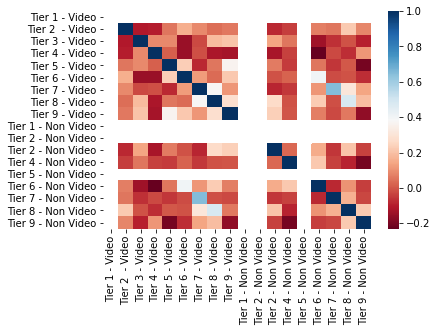

In [4]:
# calculate the correlation matrix
corr = df2.corr()

# display the correlation matrix
#display(corr)

# plot the correlation heatmap
sn.heatmap(corr, xticklabels = corr.columns, yticklabels=corr.columns, cmap = 'RdBu')

### Step 5) There is no correlation in the independent variables so VIF is not required. Remove redundant variables and plot scatter matrix


In [5]:
# #df2_cleaned = df2_dataset.drop(['Tier 1 - Non Video','Tier 2 - Non Video','Tier 1 - Video'], axis = 1)
# #df2_cleaned.describe()

# # define the plot
# pd.plotting.scatter_matrix(df2, alpha = 1, figsize = (30, 20))

# # show the plot
# plt.show()

### Step 6) Split the dataset and build the model

In [6]:

X = df2.loc['2018-01-01':'2018-04-30']
Y = df1.loc['2018-01-01':'2018-04-30']

X_Predict = df2.loc['2018-05-01':'2018-05-15']

print(X.shape)
print(Y.shape)

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.02, random_state=1)

# create a Linear Regression model object
regression = LinearRegression(normalize = True)

# pass through the X_train & y_train data set
regression.fit(X_train, y_train)

print("*"*100)


(120, 18)
(120, 1)
****************************************************************************************************


### Step 7) Test the model output and get R-square

In [7]:
# Get coefficients of the model and the intercept
intercept = regression.intercept_[0]
coefficent = regression.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

# loop through the dictionary and print the data
for coef in zip(X.columns, regression.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))
    
# Get multiple predictions
y_predict = regression.predict(X_test)
model_r2 = r2_score(y_test, y_predict)
print("Rsquare: {:.2}".format(model_r2))

print("*"*100)

The intercept for our model is 2.03e+06
----------------------------------------------------------------------------------------------------
The Coefficient for Tier 1 - Video is 0.0
The Coefficient for Tier 2  - Video is 2.2e+05
The Coefficient for Tier 3 - Video is -1.4e+05
The Coefficient for Tier 4 - Video is -2.1e+04
The Coefficient for Tier 5 - Video is -1.1e+05
The Coefficient for Tier 6 - Video is -2.2e+03
The Coefficient for Tier 7 - Video is 1.2e+05
The Coefficient for Tier 8 - Video is -1.5e+04
The Coefficient for Tier 9 - Video is -1.1e+05
The Coefficient for Tier 1 - Non Video is -2.3e-10
The Coefficient for Tier 2 - Non Video is 2.3e-10
The Coefficient for Tier 2 - Non Video is -2.4e+05
The Coefficient for Tier 4 - Non Video is 3.3e+05
The Coefficient for Tier 5 - Non Video is 4.7e-10
The Coefficient for Tier 6 - Non Video is -2.5e+04
The Coefficient for Tier 7 - Non Video is 0.0
The Coefficient for Tier 8 - Non Video is 1.4e+05
The Coefficient for Tier 9 - Non Video is -

### Step 8) Evaluate the model
#### Autocorrelation check
#### Check for Mean of the Residuals 

To evaluate the model all the assumptions have to be tested. Check for autocorrelation & if residuals are normally distributed

The number of lags will be 10
----------------------------------------------------------------------------------------------------


/Users/sagarpardeshi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


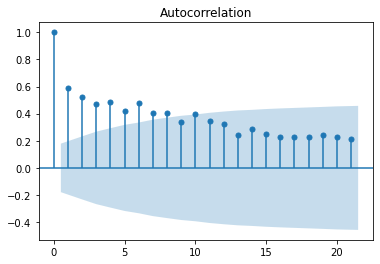

****************************************************************************************************


In [8]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

# test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
# test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
test_results = diag.acorr_ljungbox(est.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()
print("*"*100)

#### Autocorrelation exists in the input variables
The tests show autocorrelation exists. Following are the suggested solves
- increase the interval between observations (eg monthly to quarterly)
- add/delete variables
- try a different functional form
- fix up the standard errors

#### Check for Mean of the Residuals 

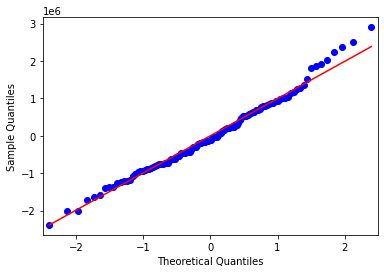

The mean of the residuals is -2.008e-09
****************************************************************************************************


In [9]:
import pylab

# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))
print("*"*100)

Residuals are very close to the mean

#### Step 9) Save the model and predict the traffic into a CSV file

In [10]:
import pickle
import csv
# pickle the model
with open('FC_Solution_1.sav','wb') as f:
     pickle.dump(regression, f)

# load it back in
with open('FC_Solution_1.sav', 'rb') as pickle_file:
     regression_2 = pickle.load(pickle_file)
        
Traffic = regression_2.predict(X_Predict)
Date = X_Predict.index
Date = Date.tolist()
Traffic = Traffic.tolist()
Result = {'Date':Date,'Traffic':Traffic}

Result = pd.DataFrame(Result)
Result.to_csv('Results.csv')
print(Result)

         Date               Traffic
0  2018-05-01  [1807620.4542098627]
1  2018-05-02  [1896176.5615606355]
2  2018-05-03   [5341761.144502225]
3  2018-05-04  [2048715.7898058114]
4  2018-05-05  [1552210.0120364411]
5  2018-05-06   [2004832.089269767]
6  2018-05-07  [1538406.3865284377]
7  2018-05-08  [1711159.8008444218]
8  2018-05-09  [1562076.5799270277]
9  2018-05-10  [3065739.1524610124]
10 2018-05-11  [3514199.5884213094]
11 2018-05-12  [1496432.7577190823]
12 2018-05-13  [2180092.7403419614]
13 2018-05-14  [1864298.4485583603]
14 2018-05-15   [1802135.296065188]
